<center><h1> Human activity recognition - Analysis</center></h1> <br>
<hr>

<h2> Part 1: Understanding the data and create baseline model

The data consists of a number of accelerometer measurements from cellphones. The 9 features are
- Triaxial acceleration from the accelerometer (total acceleration)
- Estimated body acceleration.
- Triaxial Angular velocity from the gyroscope. 

These features are measured when the test subject is performing one of these activites:
- Walking
- Walking upstairs
- Walking downstairs
- Sitting
- Standing
- Laying


In [3]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from load_data import load_data_to_numpy_array as dataloader

We start by looking qualitatively on the data by plotting random measurements of each activity. The `load_data` function just concatenates the raw datafiles to numpy arrays of shape `[measurement, features, time]` for `X` and `[measurements, labels]` for `Y`.  To reduce the number of features, we just plot the norm the $x,y,z$-components and only the rotational velocity and total acceleration. That is, we plot $\vert a_x, a_y, a_z \vert$ and $\vert \dot{r}_x, \dot{r}_y, \dot{r}_z \vert$, where $a$ is acceleration and $\dot{r}$ is rotational velocity.

In [4]:
# Load data
data_path = os.path.join(os.getcwd(), 'data')
X_train, Y_train, X_test, Y_test = dataloader(data_path)
labels = ['Walking', 'Walking upstairs', 'Walking downstairs', 'Sitting', 'Standing', 'Laying']

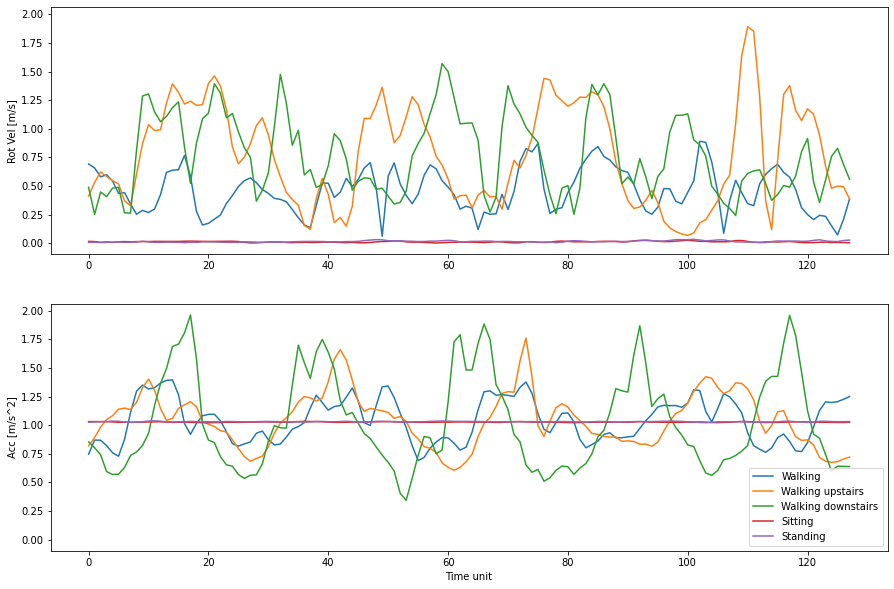

In [5]:
# Plotting
fig, ax = plt.subplots(2, sharey=True,figsize=(15,10))

for i in range(5):
    ind = np.random.randint(0,len(X_train)/10)
    ax[0].plot(np.linalg.norm(X_train[Y_train == i][ind,3:6,:], axis=0), label = labels[i])
    ax[1].plot(np.linalg.norm(X_train[Y_train == i][ind,6:9,:], axis=0), label = labels[i])
    
ax[1].set_xlabel('Time unit')
ax[0].set_ylabel('Rot Vel [m/s]')
ax[1].set_ylabel('Acc [m/s^2]')
ax[1].legend()
plt.show()

From the plots, we can almost classify the signal based on the magnitude. This approach can form a baseline to compare against. 
1. Form the mean value of rotational velocity norms for measurement in the training dataset. 
2. Calculate the norm for all measurements in the test set.
3. Compare each norm to the mean norm and choose closest one as prediction.

In [6]:
rot_vel_norms = np.linalg.norm(X_train[:,3:6,:],axis=(1,2))
rot_vel_means = np.array([rot_vel_norms[Y_train==x].mean() for x in range(5)])

rot_vel_norms_test = np.linalg.norm(X_test[:,3:6,:], axis=(1,2))

# Stack rot_vel_norms to get the error per feature (faster than looping at least)
errors = np.abs((rot_vel_norms_test.repeat(5).reshape(len(Y_test), 5) - rot_vel_means))   
correct = np.sum(np.argmin(errors,axis=1) == Y_test)

print('Correct predictions: {:.2f}%'.format(correct/len(Y_test)*100))

Correct predictions: 38.51%


Roughly 39% accuracy with this naive approach. Let us see if we can achive better results using some more sophisticated methods. 

<hr>
<h2> Part 2: Improving accuracy

<h3>a) KNN with PCA</h3><br>

In this part we try a simple K-Nearest Neighbor-analysis of dimensionality reduced data. 
The workflow is as follows
1. Use PCA to project the training data onto a subspace of lower dimensionality
2. Cluster the projected training data using KNN
3. Project the test data onto the same subspace as step 1.
4. Classify each measurement with KNN.

We import sklearn packages to perform the analysis more efficiently. `tqdm` is used to track progress. We use a simple grid search to find the best hyperparameters (number of neighbors and number of neighbors).

In [7]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm

nPCA: 9: 100%|████████████| 29/29 [00:04<00:00,  6.06 Model Fit/s, validation_accuracy=0.781]                                                                                                                                                                               


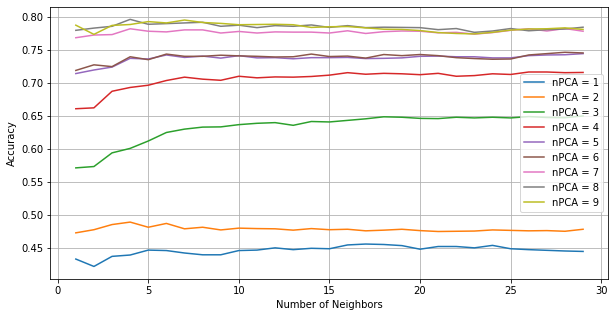

Best validation accuracy: 79.64%


In [26]:
# Hyperparameters
n_neigbors = 30
n_components = 10


fig, ax = plt.subplots(1, figsize=(10,5))
max_val = []
for m in range(1, n_components):
    
    # Project data to lower dimension
    pca = PCA(n_components=m)
    pc_train = pca.fit_transform(X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
    
    # Important: Do transform test data only based on training data PCA.
    pc_test = pca.transform(X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

    val_vec = []; n_vec = []

    with tqdm(range(1,n_neigbors), unit=" Model Fit", bar_format='{l_bar}{bar:12}{r_bar}{bar:-12b}') as trange:
        for n in trange:
            trange.set_description(f"nPCA: {m}")

            # Make KNN classification
            clf = KNeighborsClassifier(n)
            _ = clf.fit(pc_train, Y_train)

            # Predict test data
            Y_pred_val = clf.predict(pc_test)

            val_acc = (Y_pred_val==Y_test).sum() / len(Y_test)
            val_vec.append(val_acc)
            n_vec.append(n)

            trange.set_postfix(validation_accuracy='{:.3f}'.format(val_acc))
            time.sleep(0.0001)

        max_val.append(max(val_vec))

    ax.plot(n_vec, val_vec,label = 'nPCA = ' + str(m))

plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()
print('Best validation accuracy: {:.2f}%'.format(  max(max_val)*100  ))

We seem to achieve about 80% validation accuracy using a subspace of 7-8 dimensions and roughly 5 neighbors. 

<h3>b) A simple random forest approach</h3><br>
Lets see if a random forest approach can perform better straight out of the box. 

estimators: 50: 100%|████████████| 10/10 [01:19<00:00,  7.97s/ Model fit, validation_accuracy=0.835]                                                                                                                                                                        


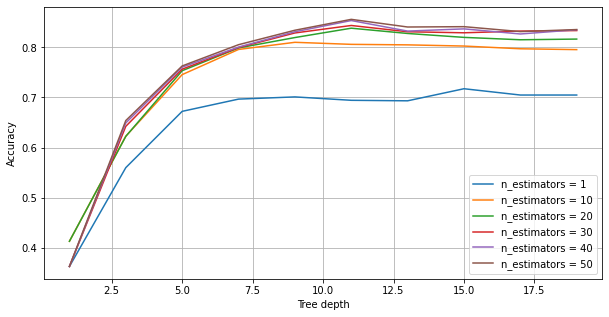

Best validation accuracy: 85.58%


In [27]:
from sklearn.ensemble import RandomForestClassifier

max_depth = 20
max_estimators = 50
fig, ax = plt.subplots(1, figsize=(10,5))

for m in [x+1 if x==0 else x for x in range(0,max_estimators+1,10)]:
    max_val = []; val_vec = []; n_vec = []
    
    with tqdm(range(1,max_depth,2), unit=" Model fit", bar_format='{l_bar}{bar:12}{r_bar}{bar:-12b}') as trange:
        for n in trange:
            trange.set_description(f"estimators: {m}")

            clf = RandomForestClassifier(n_estimators = m, max_depth=n, random_state=0, criterion = 'entropy')
            clf.fit(X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]), Y_train)

            Y_pred = clf.predict(X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

            val_acc = (Y_pred == Y_test).sum() / len(Y_test)
            val_vec.append(val_acc)
            n_vec.append(n)
            
            trange.set_postfix(validation_accuracy='{:.3f}'.format(val_acc))
            time.sleep(0.0001)
        max_val.append(max(val_vec))
        ax.plot(n_vec, val_vec, label = 'n_estimators = ' + str(m)) 
plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()
print('Best validation accuracy: {:.2f}%'.format(max(max_val)*100))

<h3>c) Deep-learning: training a CNN-LSTM model</h3><br>

In this part, we train a CNN-LSTM model to classify the same data. The model is implemented in the file `CONVLSTM.py`. 

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from CONVLSTM import CONVLSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Does the device have any GPUs?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running on:', device)

# Instantiate the model
model = CONVLSTM(hidden=64)
model

The previous approaches does not neccessarily need the data to be scaled properly, but a neural network will learn quicker if we normalize the data. For this we can use the MinMax and Standardscaler from Scikit-learn. 

In [ ]:
# Scale each feature seperately
for i in range(X_train.shape[1]):
    ss = StandardScaler()
    mm = MinMaxScaler()
    X_train[:, i, :] = ss.fit_transform(X_train[:, i, :]) 
    X_train[:, i, :] = mm.fit_transform(X_train[:, i, :])    
    X_test[:,i,:] = ss.transform(X_test[:,i,:])
    X_test[:,i,:] = mm.transform(X_test[:,i,:])

For PyTorch to work with our data, we must pack it into `torch.tensor` objects. These tensors can subsequently be packed into `TensorDataset` and `DataLoader` that makes it easier to batch and use CUDA.  

In [ ]:
batch_size = 32

dataset_train = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)
dataset_test = TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = DataLoader(dataset_test, batch_size = batch_size, shuffle=True)

In [ ]:
# Move model to GPU
model = model.to(device)

# We want to minimize the negative log-likelihood loss since the output (not seen here) outputs log-softmax.
loss_fn = torch.nn.NLLLoss()

# Use Adam optimizer and we lower the learning rate after 20 epochs by gamma. 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20], gamma=0.1)

In [ ]:
# Define a standard training loop with validation 
epochs=30

for epoch in range(epochs):
    model.train()
    correct = 0
    running_loss=0
    with tqdm(train_loader, unit=" batch", bar_format='{l_bar}{bar:12}{r_bar}{bar:-12b}') as tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        for i, (X,Y) in enumerate(tepoch):
            X = X.to(device)
            Y = Y.to(device)
            
            
            y = model(X)
            loss = loss_fn(y, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred = y.data.max(1, keepdim=True)[1]
            correct += pred.eq(Y.data.view_as(pred)).sum()
            
            running_loss += loss.item()
            acc = correct.item()/(batch_size*(i+1))
            tepoch.set_postfix(loss='{:.3f}'.format(running_loss /  (i+1)), accuracy='{:.3f}'.format(acc))
            
            if i == len(tepoch)-1:
                
                model.eval()
                test_correct = 0
                test_running_loss=0
                for i, (X,Y) in enumerate(test_loader):
                    X = X.to(device)
                    Y = Y.to(device)
                    y = model(X)
                    loss = loss_fn(y, Y)

                    pred = y.data.max(1, keepdim=True)[1]
                    test_correct += pred.eq(Y.data.view_as(pred)).sum()
                    val_acc = test_correct.item()/(batch_size*(i+1))
                tepoch.set_postfix({'Training Accuracy':acc, 'Validation Accuracy': val_acc})  
    scheduler.step()

The validation accuracy is increased to about 91%, a good result, especially considering that no feature enginnering was performed.